Install ta-lib and yfinance
```bash
wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
untar and cd  ta-lib/
./configure --prefix=/usr
make
make install
pip3 install TA-Lib yfinance matplotlib sklearn
```

In [3]:
import yfinance as yf
import talib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from sklearn import metrics
%matplotlib inline


In [6]:

ticker= "googl"
stock_data = yf.download(ticker, start="2016-01-04", end="2021-09-05")

[*********************100%***********************]  1 of 1 completed


In [7]:
stock_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-08-30,2888.000000,2919.409912,2883.260010,2891.810059,2891.810059,1221700
2021-08-31,2902.939941,2903.429932,2885.620117,2893.949951,2893.949951,1122400
2021-09-01,2900.000000,2925.080078,2897.669922,2904.310059,2904.310059,1096800
2021-09-02,2904.320068,2910.389893,2863.699951,2865.739990,2865.739990,1617100
2021-09-03,2861.610107,2883.100098,2848.010010,2874.790039,2874.790039,992500


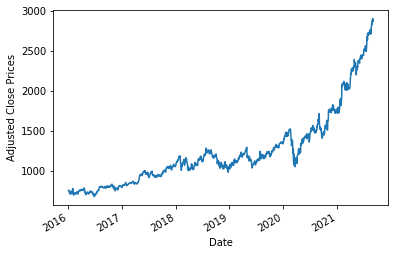

In [8]:
stock_data['Adj Close'].plot()
plt.ylabel("Adjusted Close Prices")
plt.show()

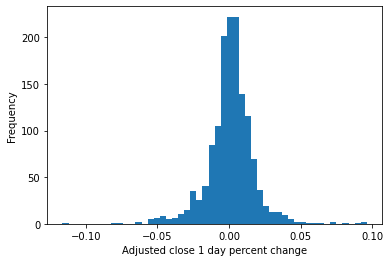

In [9]:
stock_data['Adj Close'].pct_change().plot.hist(bins=50)
plt.xlabel("Adjusted close 1 day percent change")
plt.show()

In [30]:
feature_names = []
for n in [14, 30, 50, 200]:
    stock_data['ma' + str(n)] = talib.SMA(stock_data['Adj Close'].values, timeperiod=n)
    stock_data['rsi' + str(n)] = talib.RSI(stock_data['Adj Close'].values, timeperiod=n)

    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]

In [31]:
stock_data['Volume_1d_change'] = stock_data['Volume'].pct_change()

volume_features = ['Volume_1d_change']
feature_names.extend(volume_features)
feature_names

['ma14',
 'rsi14',
 'ma30',
 'rsi30',
 'ma50',
 'rsi50',
 'ma200',
 'rsi200',
 'Volume_1d_change']

In [32]:
stock_data['5d_future_close'] = stock_data['Adj Close'].shift(-5)
stock_data['5d_close_future_pct'] = stock_data['5d_future_close'].pct_change(5)

In [33]:
stock_data.tail()

,Open,High,Low,Close,Adj Close,Volume,ma14,rsi14,ma30,rsi30,ma50,rsi50,ma200,rsi200,Volume_1d_change,5d_future_close,5d_close_future_pct
Date,,,,,,,,,,,,,,,,,
2021-08-23,2759.389893,2817.489990,2752.149902,2800.830078,2800.830078,1422700,2736.581438,69.709597,2671.967342,67.412363,2588.209399,65.478569,2170.134798,59.937773,-0.087194,NaN,0.028295
2021-08-24,2812.229980,2841.600098,2806.770020,2825.229980,2825.229980,963400,2745.347151,72.008438,2681.247339,68.593298,2595.735801,66.221638,2175.448448,60.159166,-0.322837,NaN,0.019414
2021-08-25,2832.500000,2843.790039,2827.520020,2841.580078,2841.580078,792400,2753.672154,73.461858,2690.475342,69.362918,2603.999604,66.711575,2180.857698,60.306891,-0.177496,NaN,0.013549
2021-08-26,2835.000000,2848.350098,2827.139893,2828.810059,2828.810059,1030500,2761.817871,70.387764,2700.099007,68.016249,2612.266807,65.949222,2186.194648,60.131875,0.300480,NaN,0.018124
2021-08-27,2833.050049,2890.250000,2829.939941,2880.080078,2880.080078,1438600,2771.947876,74.924658,2711.455013,70.402843,2621.171006,67.472073,2191.906449,60.593330,0.396021,NaN,0.000000


In [34]:
stock_data.dropna(inplace=True)

X = stock_data[feature_names]
# y = stock_data['5d_close_future_pct']
y = stock_data['5d_future_close']

train_size = int(0.85 * y.shape[0])
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

In [35]:
grid = {'n_estimators': [200], 'max_depth': [3], 'max_features': [4, 8], 'random_state': [42]}
test_scores = []

rf_model = RandomForestRegressor()

for g in ParameterGrid(grid):
    rf_model.set_params(**g) 
    rf_model.fit(X_train, y_train)
    test_scores.append(rf_model.score(X_test, y_test))

best_index = np.argmax(test_scores)
print(test_scores[best_index], ParameterGrid(grid)[best_index])

-4.446787294599674 {'random_state': 42, 'n_estimators': 200, 'max_features': 8, 'max_depth': 3}


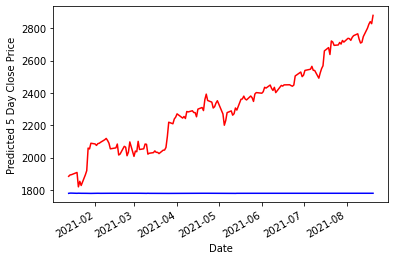

In [36]:

rf_model = RandomForestRegressor(n_estimators=200, max_depth=3, max_features=8, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

y_pred_series = pd.Series(y_pred, index=y_test.index)
y_test_series = pd.Series(y_test, index=y_test.index)
y_pred_series.plot(color='blue')
y_test_series.plot(color='red')
plt.ylabel("Predicted 5 Day Close Price")
# plt.ylabel("Predicted 5 Day Close Price Change Percent")
plt.show()

In [17]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.03890003691855319
Mean Squared Error: 0.0022277209085240827
Root Mean Squared Error: 0.047198738420895135


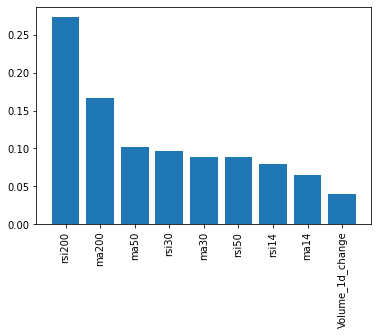

In [18]:
importances = rf_model.feature_importances_
sorted_index = np.argsort(importances)[::-1]
x_values = range(len(importances))
labels = np.array(feature_names)[sorted_index]
plt.bar(x_values, importances[sorted_index], tick_label=labels)
plt.xticks(rotation=90)
plt.show()